# artist-genre-evolution
This notebook is submitted as a prerequisite of CSMODEL and uses the [Million Song Dataset + Spotify + Last.fm Dataset](https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm/data) from Kaggle.

Our main goal is to answer the following research question:
### **"Do artists in certain music genres exhibit more change in their musical features over time than others?"**

In other words, we want to determine if an artist's genre influences how much their musical style (defined by features like `danceability`, `energy`, `acousticness`, etc.) evolves throughout their career.



## Phase 1
__________

### Dataset Description

This project utilizes the `Music_Info.csv` dataset of the wider merged dataset. This dataset is a curated collection of songs from Spotify.

The dataset is a rebuilt version and subset of  [The Million Song Dataset](http://millionsongdataset.com/). It was built up with  [lastfm-spotify-tags-sim-userdata](https://github.com/slettner/lastfm-spotify-tags-sim-userdata) ([The Echo Nest Taste Profile Subset](http://millionsongdataset.com/tasteprofile/) &  [lastfm-dataset-2020](https://github.com/renesemela/lastfm-dataset-2020)),  [tagtraum genre annotations](https://www.tagtraum.com/msd_genre_datasets.html), and  [Spotify API](https://developer.spotify.com/documentation/web-api). 

TODO: see if there are any further biases/implications by looking through the links

For each song, the dataset provides a rich set of attributes, including quantitative audio features derived from Spotify's audio analysis (e.g., danceability, energy, valence) and descriptive metadata (e.g., name, artist, year).

#### Data Collection & Potential Implications

The method of collection has several key implications for our analysis:

- **Source & Bias:** The data is sourced from Spotify, which means our insights will be specific to music available on that platform. The features are calculated by Spotify's proprietary algorithms, so we must rely on their definitions. The dataset may also have inherent biases (e.g., towards more popular, commercially successful music) which could influence our findings.
    - We are not studying the evolution of the "average" artist. We are studying the evolution of successful artists. The pressures of the commercial music industry (the need to produce hits, stay relevant, tour, etc.) might be a driving factor in why some genres evolve more than others.

- **Genre Ambiguity:** The original `genre` column is highly unreliable and often incorrect. The `tags` column provides a better, though unstructured, source for genre information. A significant part of our preprocessing will involve cleaning these tags to derive a meaningful genre for each artist or song-year combination. Furthermore, the `tags` column comes from user-generated tags - while we have indeed cleaned them, they still reflect a user-generated system rather than a strict musicological definition 

- **Temporal Relevance**: The dataset represents a snapshot in time. Song popularity is highly dynamic, and the trends identified may be specific to the period in which the data was collected. (TODO: insert the time period of data its collected); The patterns of evolution we see might be specific to the modern music industry.

- **Western-Centric Bias** (Geographic Bias): The dataset is overwhelmingly dominated by artists from North America and Europe. Our conclusions are really about the evolution of artists within the Western music industry -- We cannot claim that these patterns hold true for music in Asia, Africa, or South America, as we simply don't have enough data.



#### Structure
- **Rows:** Each row represents a single song.
- **Columns:** Each column represents a specific attribute or feature of that song.
- **Observations:** The dataset contains over 50,000 songs. TODO: add the precise number

Attributes of the Dataset
track_id             -  Unique id for each song from the original dataset

name                 -  Title of the song  

artist               -  Name of the performing artist or band

spotify_preview_url  -  Link to the audio preview from Spotify  

spotify_id           -  Spotify's internal id for the track  

tags                 -  Comma-separated user-generated tags (genre, mood, etc.)  

genre                -  Original genre label (often incomplete or unreliable) 

year                 -  Year the song was released

duration_ms          -  Duration of the song in milliseconds

danceability         -  Suitability of the track for dancing (0.0 to 1.0)  

energy               -  Intensity and activity level of the track (0.0 to 1.0)  

key                  -  Estimated key of the song (integer from 0 to 11)

loudness             -  Overall loudness in decibels (usually negative)

mode                 -  Musical mode: Major (1) or Minor (0)

speechiness          -  Presence of spoken words in the track (0.0 to 1.0)

acousticness         -  Confidence measure of whether the track is acoustic (0.0 to 1.0)

instrumentalness     -  Likelihood that the track contains no vocals (0.0 to 1.0)

liveness             -  Probability that the track was performed live (0.0 to 1.0)

valence              -  Musical positiveness or happiness (0.0 to 1.0)

tempo                -  Estimated tempo in beats per minute (BPM)

time_signature       -  Estimated number of beats per bar (e.g., 4 = 4/4)



## Step 1: Setup and Initial Data Load

We begin by importing the necessary Python libraries for data manipulation, analysis, and visualization. 

- **pandas:** For data structures and operations.
- **numpy:** For numerical operations.
- **matplotlib.pyplot & seaborn:** For creating visualizations.
- **sklearn.preprocessing.StandardScaler:** To standardize our numerical features later on.
- **scipy.stats:** For statistical tests.
- **sklearn.cluster.KMeans:** For clustering analysis.
- **collections.Counter:** To easily count tag frequencies.

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.stats as stats
from scipy.stats import f_oneway
from collections import Counter

### 1.1. Load the Dataset

Next, we load the `Music_Info.csv` file into a pandas DataFrame. We'll then use `.info()` to get a summary of the data, including column names, data types, and non-null counts. We'll also use `.head()` to preview the first few rows and get a feel for the data's structure.

In [184]:
df = pd.read_csv('Music_Info.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50683 entries, 0 to 50682
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             50683 non-null  object 
 1   name                 50683 non-null  object 
 2   artist               50683 non-null  object 
 3   spotify_preview_url  50683 non-null  object 
 4   spotify_id           50683 non-null  object 
 5   tags                 49556 non-null  object 
 6   genre                22348 non-null  object 
 7   year                 50683 non-null  int64  
 8   duration_ms          50683 non-null  int64  
 9   danceability         50683 non-null  float64
 10  energy               50683 non-null  float64
 11  key                  50683 non-null  int64  
 12  loudness             50683 non-null  float64
 13  mode                 50683 non-null  int64  
 14  speechiness          50683 non-null  float64
 15  acousticness         50683 non-null 

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


## Step 2: Data Cleaning and Preprocessing

This is the most critical phase of our analysis. The raw dataset, while rich, has several issues that must be addressed to ensure the validity of our results. Our primary challenge is the unreliable `genre` column and the unstructured nature of the `tags` column.

### 2.1. Fixing Missing and Filtering Invalid Years

We checked for missing values and invalid years. Since we will generate our own genre labels later, we ignore the original `genre` column. We also removed songs from the year 1900 (a known data error) and dropped songs without `tags`, which are essential for our genre assignment step.

In [185]:
print(df.isnull().sum())

# Drop rows where year or tags are missing
df.dropna(subset=['year', 'tags'], inplace=True)

# Filter out the problematic 1900 songs (data errors)
print(f"\n=== FILTERING OUT DATA ERRORS ===")
print(f"Before filtering: {len(df)} songs")

# Remove songs from 1900 (obvious data errors)
df = df[df['year'] != 1900]

print(f"After filtering: {len(df)} songs")

# Check the new year range
print(f"New year range: {df['year'].min()} - {df['year'].max()}")

# Verify the fix worked
remaining_old_songs = df[df['year'] < 1950]
print(f"Remaining songs before 1950: {len(remaining_old_songs)}")

if len(remaining_old_songs) > 0:
    print("Remaining old songs by year:")
    print(remaining_old_songs['year'].value_counts().sort_index())
    

track_id                   0
name                       0
artist                     0
spotify_preview_url        0
spotify_id                 0
tags                    1127
genre                  28335
year                       0
duration_ms                0
danceability               0
energy                     0
key                        0
loudness                   0
mode                       0
speechiness                0
acousticness               0
instrumentalness           0
liveness                   0
valence                    0
tempo                      0
time_signature             0
dtype: int64

=== FILTERING OUT DATA ERRORS ===
Before filtering: 49556 songs
After filtering: 49548 songs
New year range: 1919 - 2022
Remaining songs before 1950: 5
Remaining old songs by year:
year
1919    2
1933    1
1935    2
Name: count, dtype: int64


### 2.2. Cleaning the `tags` Column

The `tags` column is our best source for genre information, but it's a comma-separated string containing many non-genre words (e.g., `'love'`, `'00s'`, `'british'`). Our process is as follows:

1.  **Convert String to List:** Split the comma-separated string into a list of tags.
2.  **Define Non-Genre Tags:** Create a comprehensive list of words to filter out. This includes subjective terms, decades, locations, and other noise.
3.  **Filter and Standardize Tags:** Create a new column, `cleaned_tags`, that contains only the relevant genre tags for each song, with subgenres standardized to their parent genres (e.g., `indie_rock` becomes `rock`).

In [186]:
# Function to split and strip whitespace from tags
def split_tags(s):
    if isinstance(s, str):
        return [tag.strip() for tag in s.split(',') ]
    return []

df['tags_list'] = df['tags'].apply(split_tags)

# Define a list of common non-genre tags to exclude
non_genre_tags = ['love', 'beautiful', 'mellow', 'chill', 'sad', 'happy', 'summer', 'party',
     'workout', 'studying', 'driving', 'classic', 'live', 'cover', 'soundtrack', 'instrumental',
     'male_vocalists', 'female_vocalists', 'british', 'american', 'swedish', 'german', 'french',
     'canadian', 'australian', 'irish', 'japanese', 'spanish', 'brazilian', 'italian', 'dutch',
     'norwegian', 'finnish', 'danish', 'polish', 'russian', 'uk', 'us', 'ie', 'ca', 'au', 'de', 'fr',
     'es', 'it', 'jp', 'nl', 'se', 'no', 'fi', 'dk', 'pl', 'ru', 'br', '60s', '70s', '80s', '90s',
     '00s', '10s', '20s', 'singer_songwriter', 'guitar', 'oldies', 'acoustic', 'piano', 'chillout',
     'lounge', 'downtempo', 'experimental', 'psychedelic', 'noise', 'avant_garde']

# Function to clean and filter tags
def clean_and_filter_tags(tags):
    if not isinstance(tags, list):
        return []
    # Standardize subgenres to parent genres
    processed_tags = []
    for t in tags:
        if 'rock' in t: processed_tags.append('rock')
        elif 'pop' in t: processed_tags.append('pop')
        elif 'metal' in t: processed_tags.append('metal')
        elif 'punk' in t: processed_tags.append('punk')
        elif 'hip_hop' in t: processed_tags.append('hip-hop')
        elif t not in non_genre_tags: processed_tags.append(t)
    return sorted(list(set(processed_tags))) # Use set to get unique tags for the song

df['cleaned_tags'] = df['tags_list'].apply(clean_and_filter_tags)

# Display the original vs. cleaned tags for a few rows to verify the fix
print(df[df['artist'] == 'The Killers'][['name', 'tags_list', 'cleaned_tags']].head())

                               name  \
0                    Mr. Brightside   
5                  Somebody Told Me   
20              When You Were Young   
38  All These Things That I've Done   
50           Smile Like You Mean It   

                                            tags_list  \
0   [rock, alternative, indie, alternative_rock, i...   
5   [rock, alternative, indie, pop, alternative_ro...   
20  [rock, alternative, indie, alternative_rock, i...   
38  [rock, alternative, indie, alternative_rock, i...   
50  [rock, alternative, indie, pop, alternative_ro...   

                       cleaned_tags  
0        [alternative, indie, rock]  
5   [alternative, indie, pop, rock]  
20       [alternative, indie, rock]  
38       [alternative, indie, rock]  
50  [alternative, indie, pop, rock]  


## Step 3: Assigning Genre by Artist and Year

This is the core of our improved methodology. Instead of assigning a single genre to an artist for their entire career, we will determine their most likely genre for each year. This allows us to track genre evolution accurately.

1.  **Group by Artist and Year:** We group the DataFrame by both `artist` and `year`.
2.  **Aggregate Tags:** For each artist-year group, we collect all the `cleaned_tags` from all songs in that year.
3.  **Find Most Common Genre:** We use `collections.Counter` to find the most frequent tag for that year. This becomes the `yearly_genre`.
4.  **Merge Back:** We merge this yearly genre information back into our main DataFrame.

In [187]:
# Group by artist and year, then aggregate all cleaned tags for that year
artist_year_tags = df.groupby(['artist', 'year'])['cleaned_tags'].sum().reset_index()

# Function to find the most common genre tag
def get_most_common_genre(tags):
    if not tags:
        return 'Unknown'
    # Count frequencies and return the most common one
    return Counter(tags).most_common(1)[0][0]

artist_year_tags['yearly_genre'] = artist_year_tags['cleaned_tags'].apply(get_most_common_genre)

# Merge the yearly_genre back into the main dataframe
df = pd.merge(df, artist_year_tags[['artist', 'year', 'yearly_genre']], on=['artist', 'year'], how='left')

# Display an example of an artist who has changed genres
print('David Bowie Genre Evolution:')
print(df[df['artist'] == 'David Bowie'][['year', 'name', 'yearly_genre']].drop_duplicates().sort_values('year'))

David Bowie Genre Evolution:
       year                                    name yearly_genre
23324  1967                    When I Live My Dream         rock
18238  1967                   Love You Till Tuesday         rock
1952   1976                            Golden Years          pop
6547   1976                                    Star          pop
10180  1993                               Blue Jean     new_wave
32819  1995                     Maid Of Bond Street         rock
22449  1995                The Hearts Filthy Lesson         rock
10720  1997                           Little Wonder         rock
18409  1997                             Rubber Band         rock
18418  1997                            Telling Lies         rock
32632  1997                            Uncle Arthur         rock
25581  1997                          Silly Boy Blue         rock
38235  1997                  Please Mr. Gravedigger         rock
18049  1999                            I'm Deranged  alternat

## Step 4: Filtering for Meaningful Analysis

To ensure our analysis of evolution is robust, we need to filter our dataset to include only artists with a sufficient body of work over a meaningful period.

1.  **Drop Song Duplicates:** Now that we have assigned genres, we can drop duplicate tracks (based on `track_id`) to ensure each song is counted only once in our feature analysis.
2.  **Filter Artists:** We will keep only artists who have at least 3 unique songs released across at least 3 different years. 

In [188]:
# Filter out artists with suspicious patterns (very few songs across huge gaps)
print(f"\n=== FILTERING SUSPICIOUS ARTISTS ===")

# Find artists with large gaps but very few songs
artist_gaps = df.groupby('artist').agg({
    'year': ['min', 'max', 'nunique'],
    'track_id': 'nunique'
}).reset_index()

artist_gaps.columns = ['artist', 'earliest_year', 'latest_year', 'unique_years', 'song_count']
artist_gaps['career_span'] = artist_gaps['latest_year'] - artist_gaps['earliest_year']

# Remove artists with suspicious patterns
suspicious_artists = artist_gaps[
    (artist_gaps['career_span'] > 40) & 
    (artist_gaps['song_count'] <= 3)
]['artist']

print(f"Before filtering: {len(df)} songs")

print(f"Removing {len(suspicious_artists)} suspicious artists")
df = df[~df['artist'].isin(suspicious_artists)]

print(f"After filtering: {len(df)} songs")


# Calculate artist metrics for filtering
artist_stats = df.groupby('artist').agg(
    song_count=('track_id', 'nunique'),
    unique_years=('year', 'nunique')  # Changed from year_span
).reset_index()

# Identify eligible artists
eligible_artists = artist_stats[(artist_stats['song_count'] >= 3) & (artist_stats['unique_years'] >= 3)]['artist']

# Filter the main dataframe to include only these artists
df_final = df[df['artist'].isin(eligible_artists)].copy()

print(f'Original unique artists: {df["artist"].nunique()}')
print(f'Artists remaining after filtering: {len(eligible_artists)}')


=== FILTERING SUSPICIOUS ARTISTS ===
Before filtering: 49548 songs
Removing 17 suspicious artists
After filtering: 49507 songs
Original unique artists: 8047
Artists remaining after filtering: 2677


## Step 5: Quantifying Musical Evolution

We quantify an artist's musical change using two complementary approaches to address the limitation that averaging features can hide the range of an artist's work:

**Approach 1: Systematic Evolution (Year-over-Year Changes)**
We use Euclidean Distance to measure how an artist's average musical features change between consecutive years. This captures intentional artistic evolution and career trajectory changes.

**Approach 2: Artistic Variety (Within-Year Variance)**
We measure the variance in musical features within each year to capture how much an artist experiments and diversifies their sound. This addresses the professor's feedback about measuring variety vs just central tendency.

1. **Select & Standardize Features:** We select the numerical audio features and standardize them using `StandardScaler`. This is crucial because features are on different scales (e.g., `loudness` vs. `danceability`), and standardization ensures they contribute equally to the distance calculation.
2. **Calculate Yearly Averages & Variances:** For each artist, we group by year and compute both the average and variance for each musical feature.
3. **Compute Evolution Metrics:** 
   - **Systematic Change:** Euclidean distance between consecutive year averages
   - **Artistic Variety:** Average variance across all features for each year
4. **Combine Scores:** The final evolution profile includes both systematic change and artistic variety measures.

In [189]:
musical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                                'instrumentalness', 'liveness', 'valence', 'tempo']

# Standardize the features
scaler = StandardScaler()
df_final[musical_features] = scaler.fit_transform(df_final[musical_features])

# Initialize dictionaries to store both evolution metrics
artist_change_scores = {}
artist_variety_scores = {}

for artist in df_final['artist'].unique():
    artist_df = df_final[df_final['artist'] == artist].sort_values('year')
    
    # Group songs by year and calculate average feature vector
    yearly_avg_features = artist_df.groupby('year')[musical_features].mean()
    yearly_var_features = artist_df.groupby('year')[musical_features].var()
    
    # Calculate systematic evolution (year-over-year changes)
    distances = []
    
    years = yearly_avg_features.index.tolist()
    
    if len(yearly_avg_features) > 1:
        for i in range(len(years) - 1):
            year1 = years[i]
            year2 = years[i + 1]

            vec1 = yearly_avg_features.loc[year1].values
            vec2 = yearly_avg_features.loc[year2].values

            gap = year2 - year1  # how many years between

            # Evolution = how much their average sound changed PER YEAR [we now take into account the gap between years]
            distance = np.linalg.norm(vec1 - vec2) / gap # np.linalg.norm is a function that calculates the Euclidean distance between two vectors
            distances.append(distance)
            
    if distances:
        artist_change_scores[artist] = np.mean(distances)
    else:
        artist_change_scores[artist] = 0
    
    # Calculate artistic variety (average variance across all years)
    if len(yearly_var_features) > 0:
        # Average variance across all features and all years
        avg_variance = yearly_var_features.mean(axis=1).mean()
        artist_variety_scores[artist] = avg_variance
    else:
        artist_variety_scores[artist] = 0

# Create the final DataFrame for analysis
change_df = pd.DataFrame.from_dict(artist_change_scores, orient='index', columns=['musical_change_score'])
change_df.index.name = 'artist'

variety_df = pd.DataFrame.from_dict(artist_variety_scores, orient='index', columns=['artistic_variety_score'])
variety_df.index.name = 'artist'

# Merge both metrics
evolution_df = pd.merge(change_df, variety_df, on='artist')

# For genre-based analysis, we assign a single primary genre to each artist
primary_genres = df_final.groupby('artist')['yearly_genre'].agg(lambda x: x.mode()[0]).reset_index()
primary_genres.rename(columns={'yearly_genre': 'primary_genre'}, inplace=True)

analysis_df = pd.merge(evolution_df, primary_genres, on='artist')
print(f"Before filtering: {len(df)} songs")
analysis_df = analysis_df[analysis_df['primary_genre'] != 'Unknown']
print(f"After filtering: {len(df)} songs")


print("Evolution Metrics Preview:")
print(analysis_df.head())
print("\nSummary Statistics:")
print(analysis_df[['musical_change_score', 'artistic_variety_score']].describe())

Before filtering: 49507 songs
After filtering: 49507 songs
Evolution Metrics Preview:
            artist  musical_change_score  artistic_variety_score primary_genre
0      The Killers              1.467479                0.326237   alternative
1            Oasis              0.964987                0.514431           pop
2          Nirvana              1.589326                0.474954   alternative
3  Franz Ferdinand              1.920255                0.513450   alternative
4        Radiohead              1.677372                0.658304   alternative

Summary Statistics:
       musical_change_score  artistic_variety_score
count           2608.000000             2223.000000
mean               1.309590                0.519898
std                0.648238                0.299841
min                0.087173                0.013864
25%                0.843676                0.327076
50%                1.221432                0.467888
75%                1.702048                0.639786
max

## Step 6: Exploratory Data Analysis (EDA) & Visualization

Now we can visualize our results to answer the research question.

### 6.1. EDA 1: Distribution of Musical Evolution Metrics

These histograms show the distribution of both evolution metrics across all eligible artists:

- **Musical Change Score:** Measures systematic year-over-year evolution in average features
- **Artistic Variety Score:** Measures the average variance in features within each year

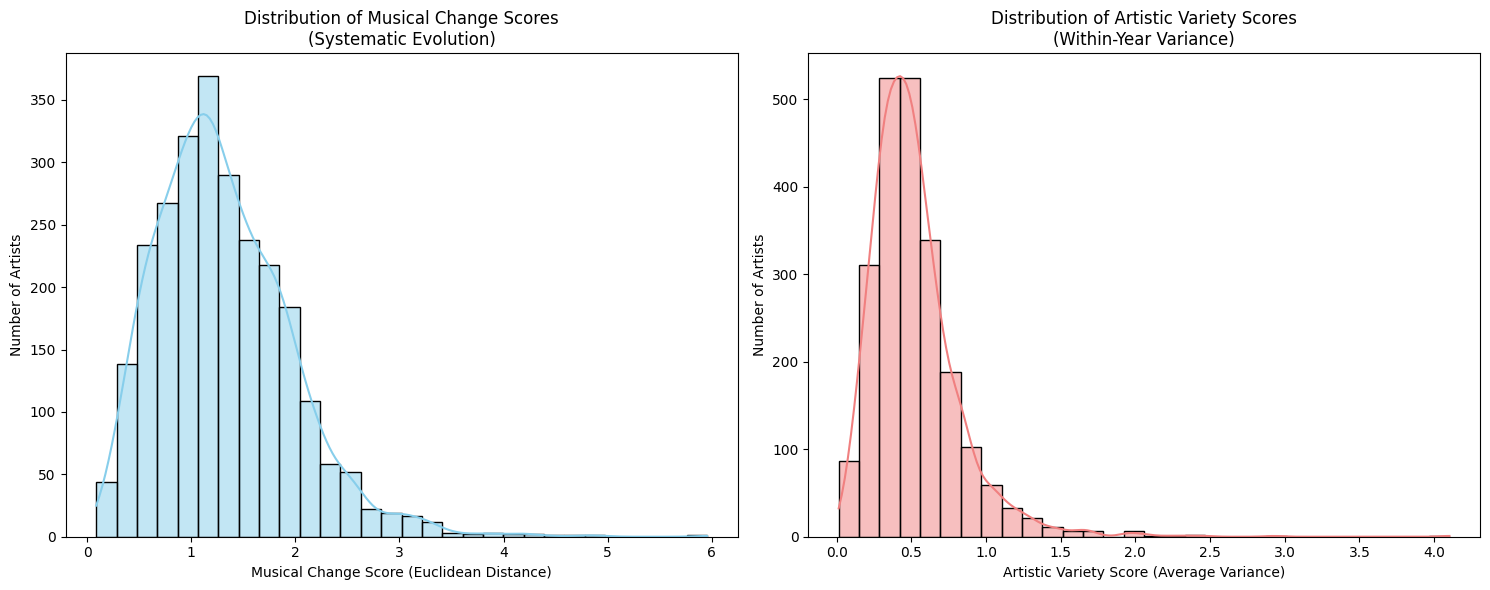

Summary Statistics for Evolution Metrics:
       musical_change_score  artistic_variety_score
count           2608.000000             2223.000000
mean               1.309590                0.519898
std                0.648238                0.299841
min                0.087173                0.013864
25%                0.843676                0.327076
50%                1.221432                0.467888
75%                1.702048                0.639786
max                5.953018                4.102895


In [190]:
# Plot histograms of both evolution metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Musical Change Score distribution
sns.histplot(data=analysis_df, x='musical_change_score', bins=30, kde=True, 
             color='skyblue', ax=ax1)
ax1.set_title('Distribution of Musical Change Scores\n(Systematic Evolution)')
ax1.set_xlabel('Musical Change Score (Euclidean Distance)')
ax1.set_ylabel('Number of Artists')

# Artistic Variety Score distribution
sns.histplot(data=analysis_df, x='artistic_variety_score', bins=30, kde=True, 
             color='lightcoral', ax=ax2)
ax2.set_title('Distribution of Artistic Variety Scores\n(Within-Year Variance)')
ax2.set_xlabel('Artistic Variety Score (Average Variance)')
ax2.set_ylabel('Number of Artists')

plt.tight_layout()
plt.show()

# Display summary statistics
print('Summary Statistics for Evolution Metrics:')
print(analysis_df[['musical_change_score', 'artistic_variety_score']].describe())

### 6.2. EDA 2: Artist Count Per Genre

Before comparing genres, we need to see how many artists we have for each one. Genres with very few artists will not be statistically reliable.

C:\Users\goaar\AppData\Local\Temp\ipykernel_12124\1410788932.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


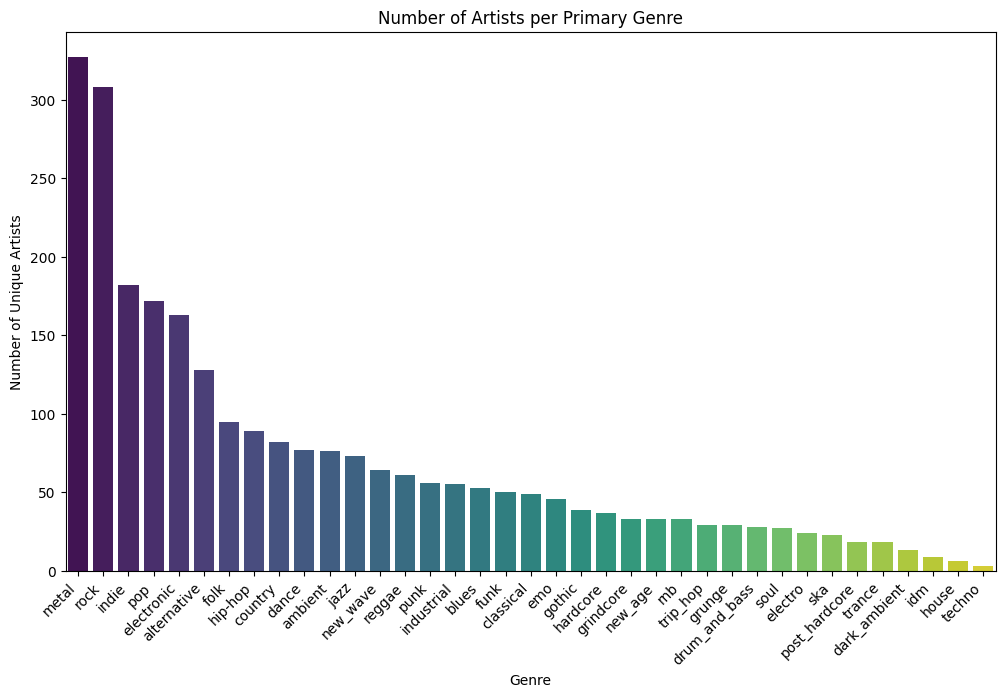

Artist Counts per Genre:
primary_genre
metal            327
rock             308
indie            182
pop              172
electronic       163
alternative      128
folk              95
hip-hop           89
country           82
dance             77
ambient           76
jazz              73
new_wave          64
reggae            61
punk              56
industrial        55
blues             53
funk              50
classical         49
emo               46
gothic            39
hardcore          37
grindcore         33
new_age           33
rnb               33
trip_hop          29
grunge            29
drum_and_bass     28
soul              27
electro           24
ska               23
post_hardcore     18
trance            18
dark_ambient      13
idm                9
house              6
techno             3
Name: count, dtype: int64


In [191]:
genre_counts = analysis_df[analysis_df['primary_genre'] != 'Unknown']['primary_genre'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel("Number of Unique Artists")
plt.title("Number of Artists per Primary Genre")
plt.show()

# Filter for genres with at least 5 artists for meaningful comparison in the next steps
reliable_genres = genre_counts[genre_counts >= 5].index.tolist()
analysis_df_filtered = analysis_df[analysis_df['primary_genre'].isin(reliable_genres)]

# Display the counts as a table
print('Artist Counts per Genre:')
print(genre_counts)

### 6.3. EDA 3: Comparing Musical Change Across Genres

This is the key visualization for our research question. The box plot allows us to compare the distribution of `musical_change_score` for each major genre. We can observe the median change, the spread (IQR), and identify any outliers.

From this, we can start to draw conclusions about which genres tend to see more or less musical evolution among their artists.

C:\Users\goaar\AppData\Local\Temp\ipykernel_12124\22313592.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df_filtered, x='primary_genre', y='musical_change_score', order=order, palette='BuGn_r')


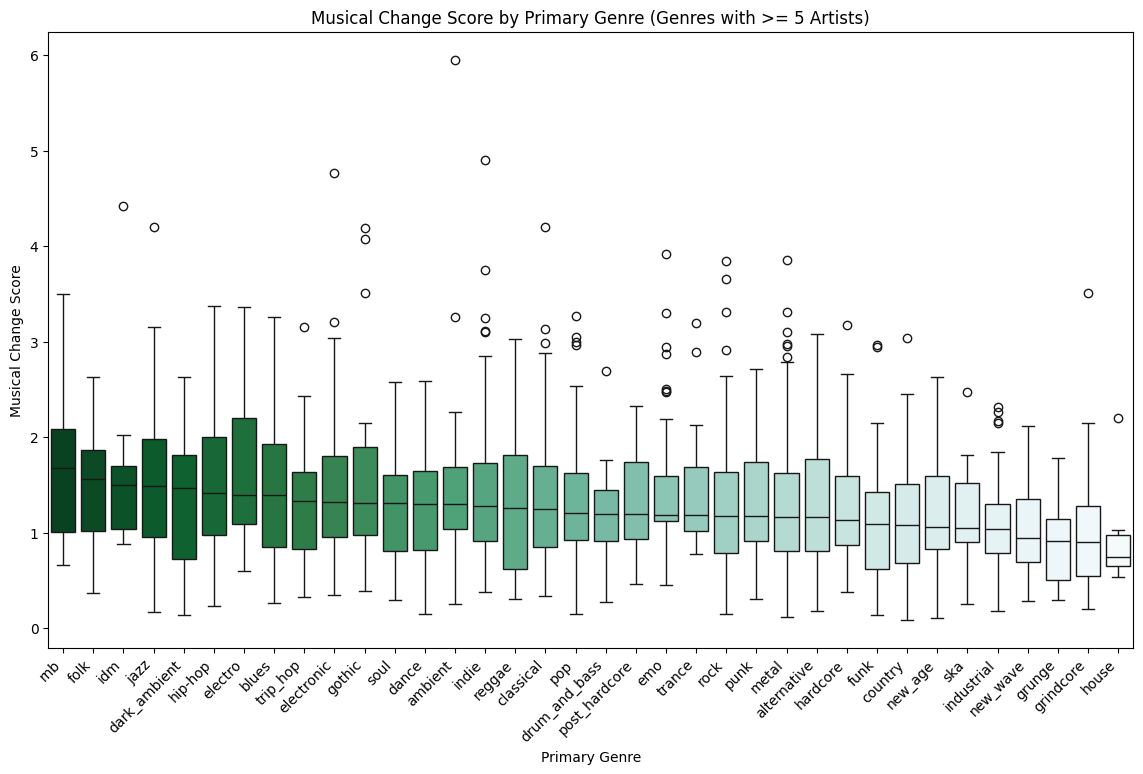

Median and Standard Deviation of Change Score per Genre:
                 median       std
primary_genre                    
rnb            1.676967  0.673898
folk           1.562559  0.569538
idm            1.497443  1.080151
jazz           1.492662  0.741121
dark_ambient   1.464766  0.804302
hip-hop        1.417173  0.719307
electro        1.392608  0.815841
blues          1.390190  0.702037
trip_hop       1.328457  0.639982
electronic     1.320780  0.636443
gothic         1.310791  0.855839
soul           1.309807  0.562319
dance          1.302260  0.581253
ambient        1.300156  0.760962
indie          1.278411  0.677095
reggae         1.258088  0.759026
classical      1.251935  0.786831
pop            1.209269  0.579830
drum_and_bass  1.198313  0.497792
post_hardcore  1.191162  0.550291
emo            1.189472  0.740903
trance         1.185076  0.697379
rock           1.176433  0.618136
punk           1.172490  0.553434
metal          1.164157  0.593008
alternative    1.162611  

In [192]:
plt.figure(figsize=(14, 8))
order = analysis_df_filtered.groupby('primary_genre')['musical_change_score'].median().sort_values(ascending=False).index
sns.boxplot(data=analysis_df_filtered, x='primary_genre', y='musical_change_score', order=order, palette='BuGn_r')
plt.title('Musical Change Score by Primary Genre (Genres with >= 5 Artists)')
plt.xlabel('Primary Genre')
plt.ylabel('Musical Change Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Display the median and standard deviation for each genre
print('Median and Standard Deviation of Change Score per Genre:')
print(analysis_df_filtered.groupby('primary_genre')['musical_change_score'].agg(['median', 'std']).sort_values('median', ascending=False))

## Phase 2
--------------------------


### Step 7: Data Mining - Clustering Artists Based on Musical Style

So far, we’ve been looking at artists and their genre labels -- like “rock”, “pop”, or “ambient”. But genres can be messy. Different people might label the same song in different ways.

Instead of relying only on genre, we wanted to group songs based on how they actually sound. To do this, we used a technique called K-Means Clustering.

Spotify gives us detailed numbers about how a song sounds:

- Is it loud or soft?

- Danceable or calm?

- Acoustic or electronic?

We used 9 of these features, including:
danceability, energy, loudness, acousticness, and tempo.

We applied K-Means to group songs that sound similar into 3 clusters.






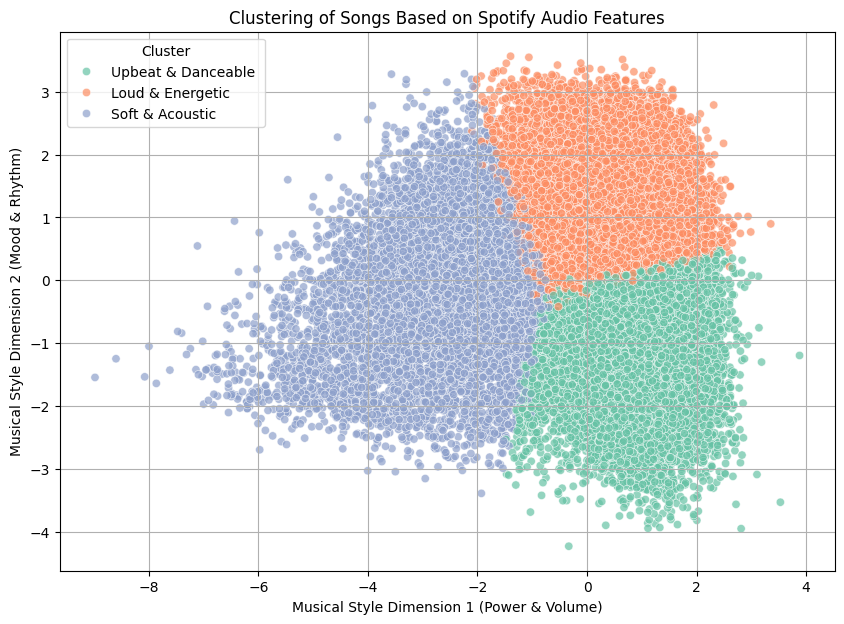

In [193]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the audio features to use for clustering
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                  'instrumentalness', 'liveness', 'valence', 'tempo']

# Extract and scale the features from the cleaned dataset
X = df_final[audio_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(2, 8)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Apply KMeans with k=3 (based on the elbow method result)
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# Map the numeric clusters to descriptive labels
cluster_names = {
    0: 'Upbeat & Danceable ',
    1: 'Loud & Energetic ',
    2: 'Soft & Acoustic'
}

df_final['Cluster_Description'] = df_final['Cluster_Label'].map(cluster_names)

# Use PCA to reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_final['PCA1'] = X_pca[:, 0]
df_final['PCA2'] = X_pca[:, 1]

# Plot the clusters in 2D PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_final, 
    x='PCA1', 
    y='PCA2', 
    hue='Cluster_Description', 
    palette='Set2', 
    alpha=0.7
)
plt.xlabel('Musical Style Dimension 1 (Power & Volume)')
plt.ylabel('Musical Style Dimension 2 (Mood & Rhythm)')
plt.title('Clustering of Songs Based on Spotify Audio Features')

plt.legend(title='Cluster')
plt.grid(True)
plt.show()


The clustering produced three natural groups of artists:

- **Loud & Energetic** 
- **Soft & Acoustic** 
- **Upbeat & Danceable** 

These clusters gave us an alternative to genre - naturally grouping artists by **how their music feels**, not just by label. 

## **=== A deeper dive on how we got this ===**

### 📍 How Did We Choose 3 Clusters? (The Elbow Method)

When using K-Means clustering, you have to tell it how many clusters (groups) to create.

But how do we decide that? 

We don’t want too few groups (they’ll be too broad), or too many (they’ll be noisy and meaningless).

To find the **best number of clusters**, we used a technique called the **Elbow Method**.

### 🦴 What’s the Elbow Method?

We tried clustering with different values of k (number of clusters) - from 2 to 7 - and measured how well the songs fit into those clusters using a score called inertia (basically, how tight the clusters are).

Then we plotted the results. The curve looks like this:





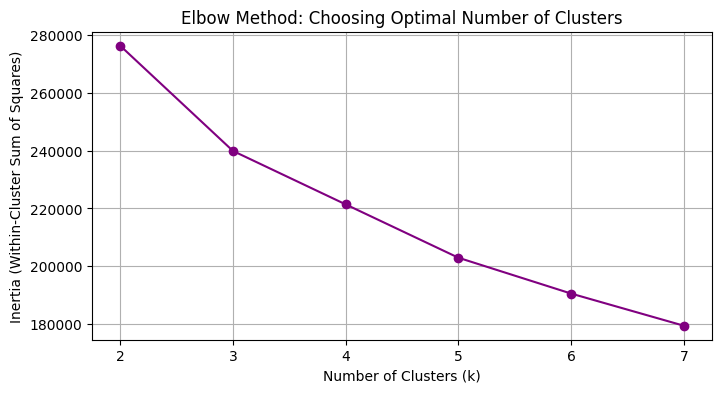

In [194]:
# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o', color='purple')
plt.title('Elbow Method: Choosing Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

The point where the curve starts to flatten out is the "elbow" -
That's where adding more clusters stops helping much.

In our plot, the elbow appeared at k = 3, so we chose 3 clusters for the rest of our analysis.

This method helps make sure we’re choosing a number of clusters that’s balanced - not too general, not too specific. It’s a simple but powerful way to improve the quality of our results before jumping into deeper analysis.

In [195]:
print("PCA Component 1 Loadings:")
print(dict(zip(audio_features, pca.components_[0])))
print("PCA Component 2 Loadings:")
print(dict(zip(audio_features, pca.components_[1])))

PCA Component 1 Loadings:
{'danceability': np.float64(0.0356201947400071), 'energy': np.float64(0.5532220273121641), 'loudness': np.float64(0.5287911508895142), 'speechiness': np.float64(0.17393942338164897), 'acousticness': np.float64(-0.49555814379525315), 'instrumentalness': np.float64(-0.19796943166674855), 'liveness': np.float64(0.13599628425450358), 'valence': np.float64(0.19656510755906695), 'tempo': np.float64(0.2022349756123146)}
PCA Component 2 Loadings:
{'danceability': np.float64(0.6514253466802046), 'energy': np.float64(-0.13015387560142655), 'loudness': np.float64(-0.017699556272089224), 'speechiness': np.float64(-0.0954062062120868), 'acousticness': np.float64(0.1061335878825302), 'instrumentalness': np.float64(-0.32780512827842295), 'liveness': np.float64(-0.23754324683348807), 'valence': np.float64(0.6007055185025065), 'tempo': np.float64(-0.11530356982538552)}


### 🧠 What Is PCA and Why Did We Use It?

We used something called Principal Component Analysis (PCA) to make our cluster results easier to see.

Spotify gives us a lot of information about each song - things like how loud, energetic, or danceable it is. That’s great, but it’s also too many dimensions to plot on a simple chart.

PCA helps us by reducing all that information into just two new dimensions that summarize the most important differences between songs. You can think of it like:

> "Let’s squish 9 musical traits down into 2 axes, so we can draw it on a graph — while still keeping most of the meaning."

In our case:

- X-axis = a mix of loudness, energy, and acousticness → we called it “Power & Volume”

- Y-axis = a mix of danceability, valence (happiness), and others → we called it “Mood & Rhythm”

Each dot in the plot is a song. The color shows what cluster it belongs to (based on audio features).

This PCA view helped us:

- Understand what makes each cluster musically different.

- See how songs naturally group by style, even without genre labels.

- Prepare for our statistical tests later on (ANOVA).

### Do the Clusters Match the Genres?

Although clustering was unsupervised (no genre info was used), we can still examine whether certain genres are more common in each cluster...


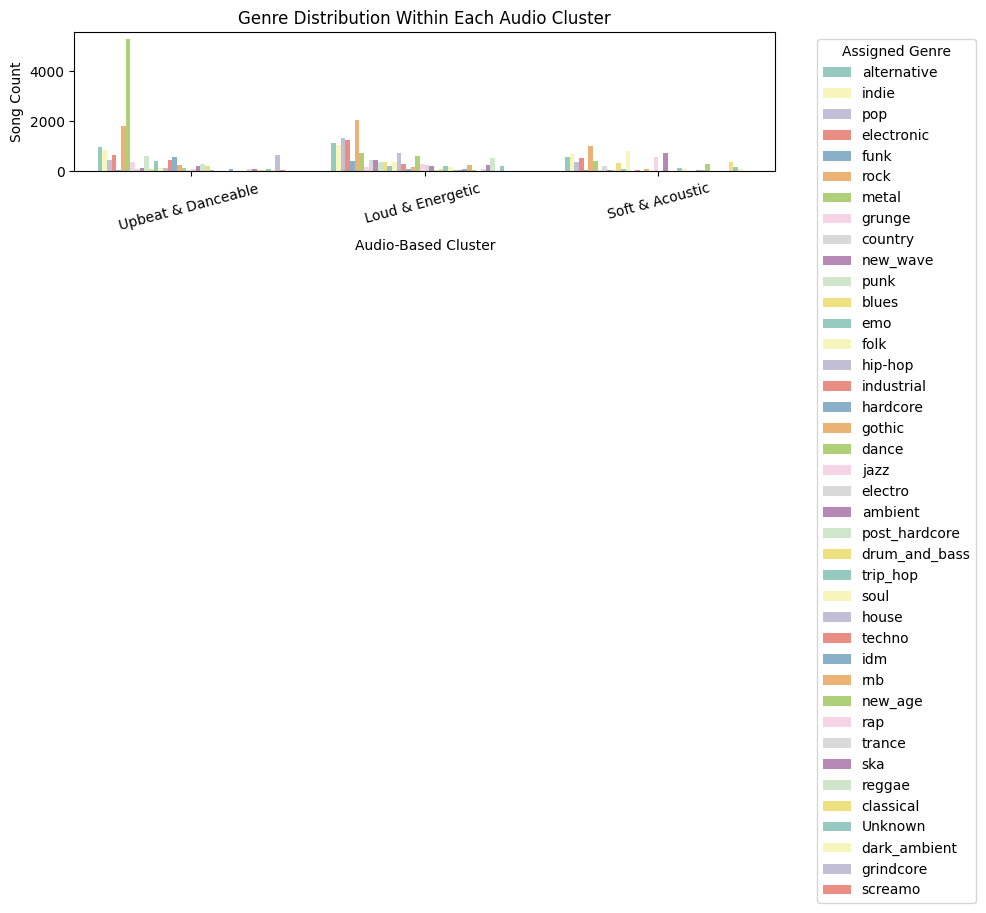

    Cluster_Description yearly_genre  count
0     Loud & Energetic          rock   2071
1     Loud & Energetic           pop   1322
2     Loud & Energetic    electronic   1263
3     Loud & Energetic   alternative   1114
4     Loud & Energetic         indie   1038
5       Soft & Acoustic         rock    996
6       Soft & Acoustic         folk    809
7       Soft & Acoustic      ambient    751
8       Soft & Acoustic        indie    681
9       Soft & Acoustic  alternative    592
10  Upbeat & Danceable         metal   5300
11  Upbeat & Danceable          rock   1798
12  Upbeat & Danceable   alternative    991
13  Upbeat & Danceable         indie    870
14  Upbeat & Danceable    electronic    666


C:\Users\goaar\AppData\Local\Temp\ipykernel_12124\4027208746.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_genres = cluster_genre_counts.groupby('Cluster_Description').apply(


In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_final,
    x='Cluster_Description',
    hue='yearly_genre',  # or 'genre' if you renamed it back
    palette='Set3'
)
plt.title('Genre Distribution Within Each Audio Cluster')
plt.xlabel('Audio-Based Cluster')
plt.ylabel('Song Count')
plt.legend(title='Assigned Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


cluster_genre_counts = df_final.groupby(['Cluster_Description', 'yearly_genre']).size().reset_index(name='count')

# Top 5 genres per cluster
top_genres = cluster_genre_counts.groupby('Cluster_Description').apply(
    lambda g: g.sort_values('count', ascending=False).head(5)
).reset_index(drop=True)

print(top_genres)


Interestingly, the cluster we labeled as ‘Upbeat & Danceable’ based on energy and rhythm features was dominated by metal genres — suggesting that modern metal often shares traits with dance or EDM tracks in Spotify’s feature space.

### Step 8: Statistical Inference
Now, we have two sources of data - the clustering based on sound, and the genre-assignment done by sorting through user-made-tags. Now, ....

#### Step 8.1: Statistical Test 1: One-Way ANOVA - Do Artists in Different Clusters Evolve Differently?

Now that we’ve grouped songs by sound (not genre), we can test our central question, just slightly reworded now:

> Do artists who make different styles of music show different levels of change over time?

We measured each artist’s musical change score — which tracks how much their sound shifts across the years.

Then we grouped the artists by their cluster label and ran a statistical test to compare their average change scores.


### 📌 Hypotheses

- **Null Hypothesis (H₀):** The average musical change score is the same for all clusters. (p >= 0.05)
- **Alternative Hypothesis (H₁):** At least one cluster has a different mean musical change score. (p < 0.05)

If we reject the null, we’ll follow up with **Tukey’s HSD** to see which clusters differ.


In [197]:
from collections import Counter

# Group by artist and get their most frequent cluster
artist_clusters = df_final.groupby('artist')['Cluster_Label'].agg(
    lambda labels: Counter(labels).most_common(1)[0][0]
).reset_index().rename(columns={'Cluster_Label': 'primary_cluster'})

# Optional: map cluster label to description
cluster_names = {
    0: 'Upbeat & Danceable',
    1: 'Loud & Energetic',
    2: 'Soft & Acoustic'
}
artist_clusters['Cluster_Description'] = artist_clusters['primary_cluster'].map(cluster_names)

# Merge with artist-level data
analysis_df = analysis_df.merge(artist_clusters[['artist', 'Cluster_Description']], on='artist', how='left')

# Group the change scores by cluster
grouped_scores = analysis_df.groupby('Cluster_Description')['musical_change_score'].apply(list)

# Prepare input for ANOVA: a list of groups
anova_input = grouped_scores.tolist()

f_stat, p_value = f_oneway(*anova_input)

print("ANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
 


ANOVA Results:
F-statistic: 9.0176
p-value: 0.0001


Since our p-value was less than 0.05, we reject the null hypothesis. We now do Post-Hoc Test.

### 🔍 Tukey HSD Interpretation

Our ANOVA test showed a significant difference in musical change scores across the three clusters. To explore which pairs of clusters differ, we used Tukey’s HSD post-hoc test.

The results show:
- **Loud & Energetic** artists change significantly more over time than both **Soft & Acoustic** and **Upbeat & Danceable** artists.
- **Soft & Acoustic** artists change the least on average.

This suggests that artists in **high-energy, loud genres** (like rock or punk) tend to evolve more in their sound over time than artists in more relaxed, acoustic genres.

Even though we didn’t directly test genre names like “rock” or “folk,” these clusters reflect genre-like groupings based on audio characteristics — making our test meaningful for analyzing artistic evolution across styles.


In [198]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Make sure 'Cluster_Description' is treated as a category
analysis_df['Cluster_Description'] = analysis_df['Cluster_Description'].astype('category')

# Drop missing values (important to avoid error)
tukey_df = analysis_df[['musical_change_score', 'Cluster_Description']].dropna()

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(
    endog=tukey_df['musical_change_score'],       # dependent variable
    groups=tukey_df['Cluster_Description'],       # group labels
    alpha=0.05                                     # significance level
)

print(tukey_result.summary())


           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1            group2       meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
Loud & Energetic    Soft & Acoustic   0.1406 0.0002   0.058 0.2232   True
Loud & Energetic Upbeat & Danceable   0.0005 0.9998 -0.0656 0.0666  False
 Soft & Acoustic Upbeat & Danceable  -0.1401 0.0004 -0.2263 -0.054   True
-------------------------------------------------------------------------


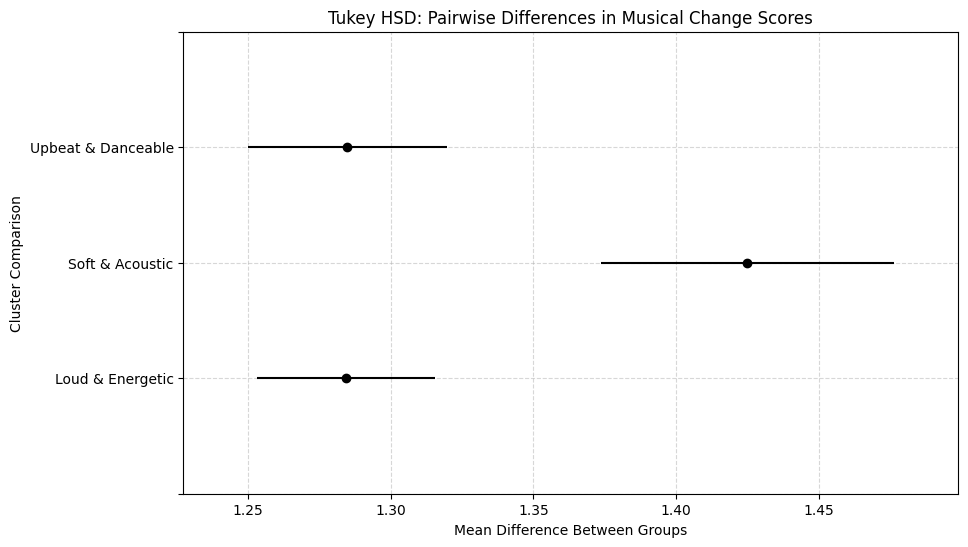

In [199]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Get the pairwise data from the Tukey result
tukey_result.plot_simultaneous(
    comparison_name=None,
    xlabel='Mean Difference Between Groups',
    ylabel='Cluster Comparison'
)
plt.title('Tukey HSD: Pairwise Differences in Musical Change Scores')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


The mean musical change score (dots) and 95% confidence intervals (horizontal lines) for each cluster are displayed in this Tukey HSD illustration.  

So, what does this tell us?

> Artists who make high-energy, intense music (like rock or punk) are more likely to evolve their sound over time.

In contrast, artists who focus on soft, ambient, or acoustic styles tend to stick to a consistent sound across their career.

This supports our idea that musical style — not just genre — affects how artists change.

Now, lets compare our cluster-based analysis with one based on our original genre analysis

In [200]:
# Count artists per genre
genre_counts = analysis_df['primary_genre'].value_counts()

# Keep only genres with >= 20 artists
valid_genres = genre_counts[genre_counts >= 30].index
filtered_genre_df = analysis_df[analysis_df['primary_genre'].isin(valid_genres)].copy()

# Group change scores by genre
genre_groups = filtered_genre_df.groupby('primary_genre')['musical_change_score'].apply(list)

# Prepare and run ANOVA
anova_input = genre_groups.tolist()
f_stat, p_value = f_oneway(*anova_input)

print("Genre-Based ANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

tukey_genre_result = pairwise_tukeyhsd(
    endog=filtered_genre_df['musical_change_score'],
    groups=filtered_genre_df['primary_genre'],
    alpha=0.05
)

print(tukey_genre_result.summary())
print(analysis_df['primary_genre'].isna().sum())
print(analysis_df['primary_genre'].value_counts().head())


Genre-Based ANOVA Results:
F-statistic: 3.7726
p-value: 0.0000
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1     group2   meandiff p-adj   lower   upper  reject
-------------------------------------------------------------
alternative    ambient   0.1069    1.0 -0.2315  0.4453  False
alternative      blues   0.1864 0.9877 -0.1953  0.5682  False
alternative  classical   0.1324    1.0 -0.2602   0.525  False
alternative    country  -0.1338 0.9992 -0.4644  0.1967  False
alternative      dance   -0.007    1.0  -0.344    0.33  False
alternative electronic   0.1242 0.9959 -0.1518  0.4002  False
alternative        emo    0.195 0.9886 -0.2068  0.5967  False
alternative       folk   0.1591 0.9823 -0.1574  0.4755  False
alternative       funk  -0.1592  0.999  -0.549  0.2305  False
alternative     gothic   0.2336 0.9539 -0.1938   0.661  False
alternative  grindcore  -0.2625 0.9222 -0.7187  0.1938  False
alternative   hardcore   0.0344    1.0 -0.4018  0.4706  False
alterna

In [201]:
print(analysis_df['primary_genre'].isna().sum())
print(analysis_df['primary_genre'].value_counts().head())


0
primary_genre
metal         327
rock          308
indie         182
pop           172
electronic    163
Name: count, dtype: int64


#### Step 8.2: T-Test

#### Step 8.3: 

## Insights and Conclusions

At the end of the Notebook, you must include a summary of the key findings and insights that were generated from the
project. Make sure that all conclusions are backed up with evidence and statiscal tests from the empirical data.
Keep in mind that you must produce a cohesive data narrative about your dataset. That is, the process that you do
in the project, including the data mining and statistical inference requirements, must tie together into a meaningful story
centered around your general research question. The insights and conclusions at the end of the Notebook must provide a
satisfying resolution to the narrative you are telling.

## GENERATIVE AI USE

During the preparation of this work the author(s) used CHATGPT and GOOGLE GEMINI for the following purposes:
- formatting
- proofreading
- aid in understanding concepts
- mental support

After using this tool/service, the author(s) reviewed and edited the content as needed and take(s) full responsibility for the content of the publication.